# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove unwanted images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [45]:
def load_images_from_directory(directory, image_size=(256, 256), batch_size=32):
    image_paths = []
    labels = []
    class_names = os.listdir(directory)
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            image_paths.append(img_path)
            labels.append(class_indices[class_name])

    # Create a TensorFlow Dataset
    def preprocess_image(img_path, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image).shuffle(buffer_size=len(image_paths)).batch(batch_size)
    return dataset

data = load_images_from_directory('data')


In [46]:
data_iterator = data.as_numpy_iterator()

In [47]:
batch = data_iterator.next()

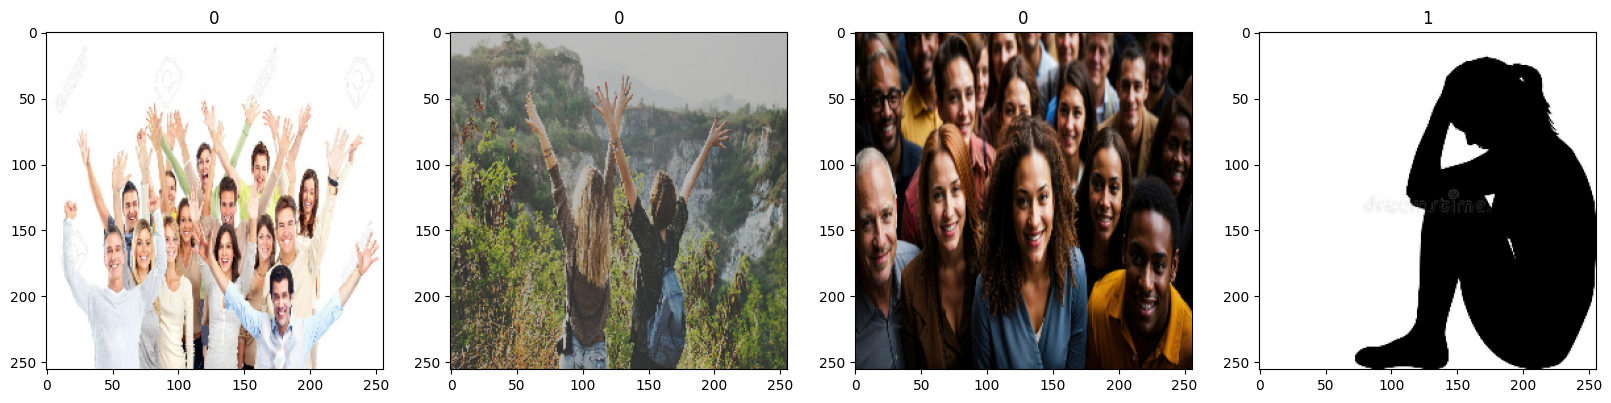

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [49]:
data = data.map(lambda x,y: (x/255, y))

In [50]:
data.as_numpy_iterator().next()

(array([[[[3.03431362e-01, 4.02450979e-01, 5.01960814e-01],
          [3.11274499e-01, 4.08823520e-01, 5.09803951e-01],
          [3.07352930e-01, 3.98529410e-01, 5.13235271e-01],
          ...,
          [2.02941179e-01, 3.00980389e-01, 4.37745094e-01],
          [2.00000003e-01, 2.93627441e-01, 4.28431362e-01],
          [1.98529407e-01, 2.95588225e-01, 4.28921580e-01]],
 
         [[3.05392146e-01, 4.03431386e-01, 5.08333325e-01],
          [3.00980389e-01, 3.99019599e-01, 5.09313703e-01],
          [3.12745094e-01, 4.01470602e-01, 5.10294139e-01],
          ...,
          [2.05392152e-01, 3.03431362e-01, 4.34803933e-01],
          [2.00980395e-01, 3.01960796e-01, 4.37254906e-01],
          [2.02941179e-01, 3.01470578e-01, 4.35784310e-01]],
 
         [[3.01960796e-01, 3.92156869e-01, 5.00490189e-01],
          [3.03431362e-01, 4.01960790e-01, 5.03431380e-01],
          [3.13725501e-01, 4.00000006e-01, 5.05882382e-01],
          ...,
          [2.12745100e-01, 3.06862742e-01, 4.4803

# 5. Split Data

In [51]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [52]:
len(data), train_size, val_size, test_size

(8, 5, 2, 1)

In [53]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [54]:
train

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [56]:
model = Sequential()

In [57]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

# 7. Train the model

In [60]:
logdir='logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 4s 508ms/step - loss: 1.2014 - accuracy: 0.4475 - val_loss: 0.7335 - val_accuracy: 0.4219
Epoch 2/20
5/5 [==============================] - 4s 445ms/step - loss: 0.6977 - accuracy: 0.5429 - val_loss: 0.5494 - val_accuracy: 0.6094
Epoch 3/20
5/5 [==============================] - 4s 482ms/step - loss: 0.5422 - accuracy: 0.6836 - val_loss: 0.4521 - val_accuracy: 0.8906
Epoch 4/20
5/5 [==============================] - 4s 468ms/step - loss: 0.4404 - accuracy: 0.8787 - val_loss: 0.3982 - val_accuracy: 0.8281
Epoch 5/20
5/5 [==============================] - 4s 464ms/step - loss: 0.3771 - accuracy: 0.8463 - val_loss: 0.2582 - val_accuracy: 0.9062
Epoch 6/20
5/5 [==============================] - 4s 468ms/step - loss: 0.2103 - accuracy: 0.9611 - val_loss: 0.2329 - val_accuracy: 0.9375
Epoch 7/20
5/5 [==============================] - 4s 513ms/step - loss: 0.2065 - accuracy: 0.9252 - val_loss: 0.1472 - val_accuracy: 0.9219
Epoch 8/20
5/5 [====

# 8. Plot Performance

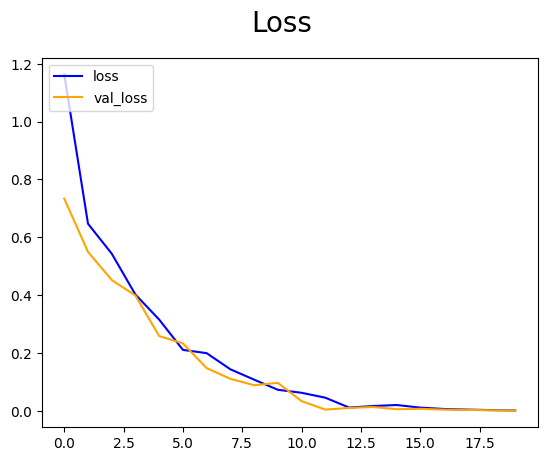

In [63]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

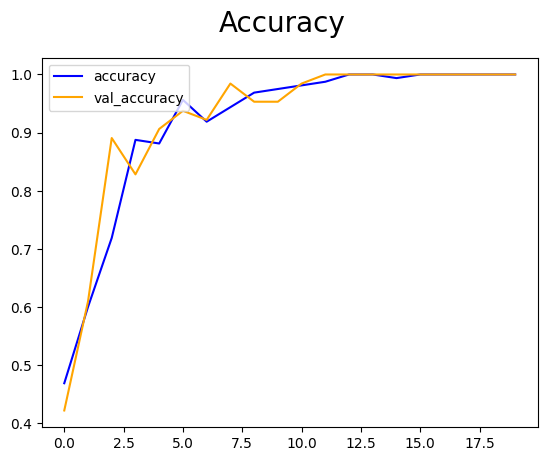

In [64]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate the model

In [65]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [68]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test on new data

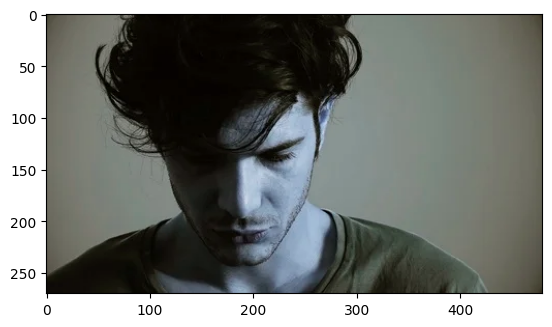

In [69]:
img = cv2.imread('sadd.jpg')
plt.imshow(img)
plt.show()

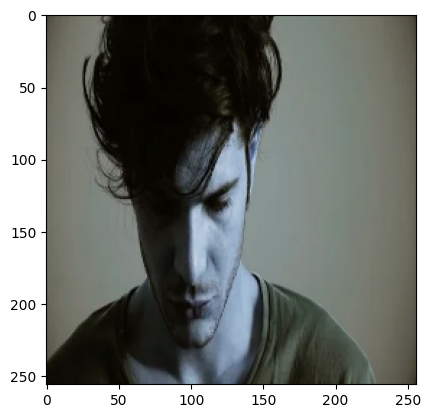

In [70]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [71]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [72]:
yhat

array([[0.9999635]], dtype=float32)

In [73]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [74]:
from tensorflow.keras.models import load_model

In [75]:
model.save('Emotion.h5')

In [76]:
new_model = load_model('Emotion.h5')

In [77]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.9999635]], dtype=float32)